### Определения и пояснения отдельных показателей

In [ ]:
# strike price — цена, установленная в опционе, по которой покупатель опциона может купить 
# (при опционе колл) или продать (при опционе пут) базовый актив по действующему опциону, 
# а продавец опциона соответственно обязан продать или купить соответствующее количество базового актива.

# Trading Volume refers to the number of trades completed each day and is an important measure 
# of strength and interest in a particular trade. 

# Open interest reflects the number of contracts that are held by traders
# and investors in active positions, ready to be traded.

### Вспомогательные ссылки

In [ ]:
# https://blog.dataiku.com/using-deep-learning-for-better-option-pricing

# xticklabels
# https://stackoverflow.com/questions/68046283/x-tick-labels-for-timeseries-in-multiindex-pandas-plot

# matplotlib colors
# https://matplotlib.org/2.1.1/gallery/color/named_colors.html

# matplotlib line styles
# https://pyprog.pro/mpl/mpl_plot.html

In [15]:
# !pip install yahoo_fin
# !pip install yoptions
# !pip install pandas_datareader
# pip install lightgbm
# !pip install --upgrade xlrd

In [14]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import os
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import data
from functools import reduce
import yoptions as yo
from yahoo_fin import options
from scipy.stats import norm
from tabulate import tabulate

# I. Визуализация для теоретической части

In [ ]:
# Датафрейм только для теоретической части (визуализация):
options = pd.read_csv('C:/Users/pshein/Desktop/Другое/Учёба/Выгрузки/JPX Tokyo/jpx-tokyo-stock-exchange-prediction/train_files/options.csv')

options.Putcall = options.Putcall.apply(lambda x: str(x).replace('1', 'Put').replace('2', 'Call'))
options.Date = pd.to_datetime(options.Date) 
options['year'] = options['Date'].dt.year
options['month'] = options['Date'].dt.month

## Японские Опционы биржи JPX (Только для графика)

### Описательная статистика

In [47]:
print('Минимальная Дата:', min(options.Date))
print('Максимальная Дата:', max(options.Date), '\n')

print('Количество уникальных опционных контрактов:', options.OptionsCode.nunique(), '\t')

Минимальная Дата: 2017-01-04
Максимальная Дата: 2021-12-03 

Количество уникальных опционных контрактов: 14732 	


### Динамика Open Interest, Trading Volume

In [179]:
put_stat = options.loc[options.Putcall == "Put"].groupby(['year', 'month']) \
                                                  .agg({'TradingVolume': 'sum',
                                                        'OpenInterest': 'sum'})
call_stat = options.loc[options.Putcall == "Call"].groupby(['year', 'month']) \
                                                  .agg({'TradingVolume': 'sum',
                                                        'OpenInterest': 'sum'})

put_stat['TM_3mean'] = put_stat.TradingVolume.rolling(window = 3).mean()
put_stat['OI_3mean'] = put_stat.OpenInterest.rolling(window = 3).mean()
call_stat['TM_3mean'] = call_stat.TradingVolume.rolling(window = 3).mean()
call_stat['OI_3mean'] = call_stat.OpenInterest.rolling(window = 3).mean()

put_stat = put_stat.iloc[:-1,:] 
call_stat = call_stat.iloc[:-1,:] # Убираем огрызок в виде декабря 2021 года

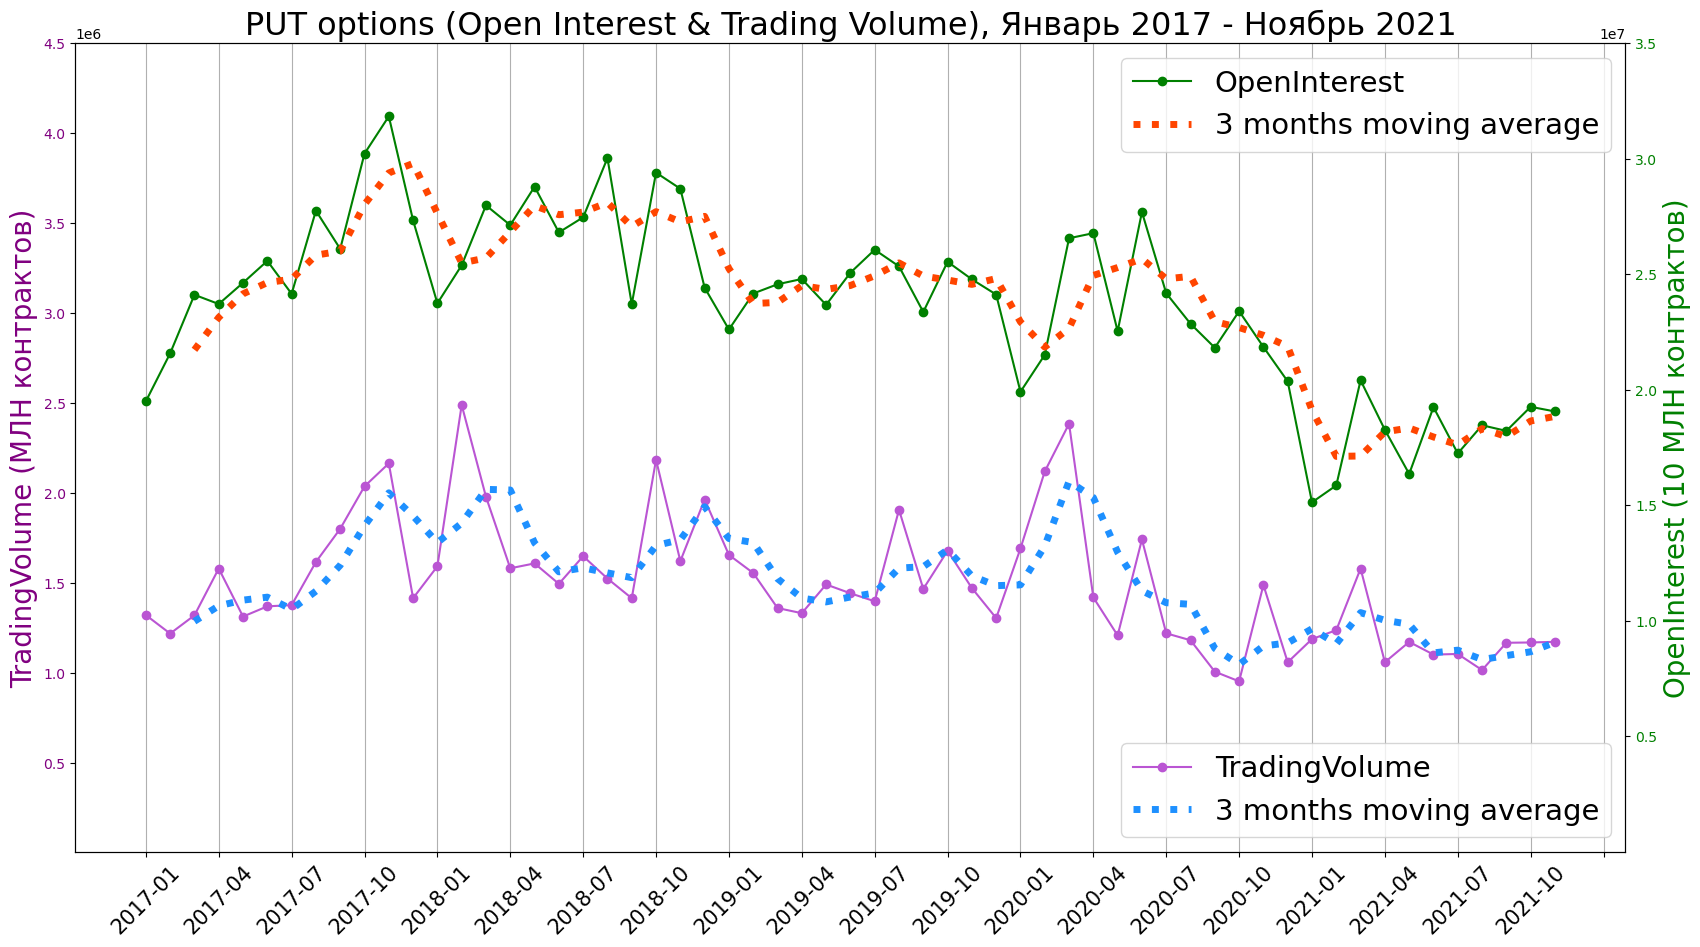

In [263]:
fig,ax = plt.subplots()

TradingVolume = ax.plot(list(put_stat.TradingVolume),
        color = 'mediumorchid',
         marker = 'o', 
         label='TradingVolume')

TM_3mean = ax.plot(list(put_stat['TM_3mean']),
        color = 'dodgerblue',
        linestyle = ':',
        linewidth = 5, 
         label='3 months moving average')

ax.set_ylabel("TradingVolume (МЛН контрактов)", 
              fontsize = 20)
plt.legend(fontsize = 21, loc = 4)

ax2 = ax.twinx() #____________________________________________

ax2.plot(list(put_stat.OpenInterest),
         color = 'green',
         marker = 'o', 
         label='OpenInterest')

ax2.plot(list(put_stat['OI_3mean']),
         color = 'orangered',
         linestyle = ':',
         linewidth = 5,
         label='3 months moving average')

ax2.set_ylabel("OpenInterest (10 МЛН контрактов)", 
              fontsize = 20)

#_____________________________________________________________

ax.set_xticks(range(len(put_stat)))
ax.set_xticklabels(["%s-%02d" % item for item in put_stat.index.tolist()], fontsize = 15, rotation = 45);
ax.grid(axis = 'x')

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3)) # значение 1 - все даты, 2 - через одну;

ax.set_ylim(10000, 4500000)
ax2.set_ylim(1,35000000)

[t.set_color('purple') for t in ax.yaxis.get_ticklines()]
[t.set_color('purple') for t in ax.yaxis.get_ticklabels()]
ax.yaxis.label.set_color('purple')

[t.set_color('green') for t in ax2.yaxis.get_ticklines()]
[t.set_color('green') for t in ax2.yaxis.get_ticklabels()]
ax2.yaxis.label.set_color('green')

# ax.set_yticklabels(list(put_stat.TradingVolume), Fontsize= 20)
# ax2.set_yticklabels(list(put_stat.OpenInterest), Fontsize= 20)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)
plt.title('PUT options (Open Interest & Trading Volume), Январь 2017 - Ноябрь 2021', fontsize = 23)
plt.legend(fontsize = 21)

plt.show()

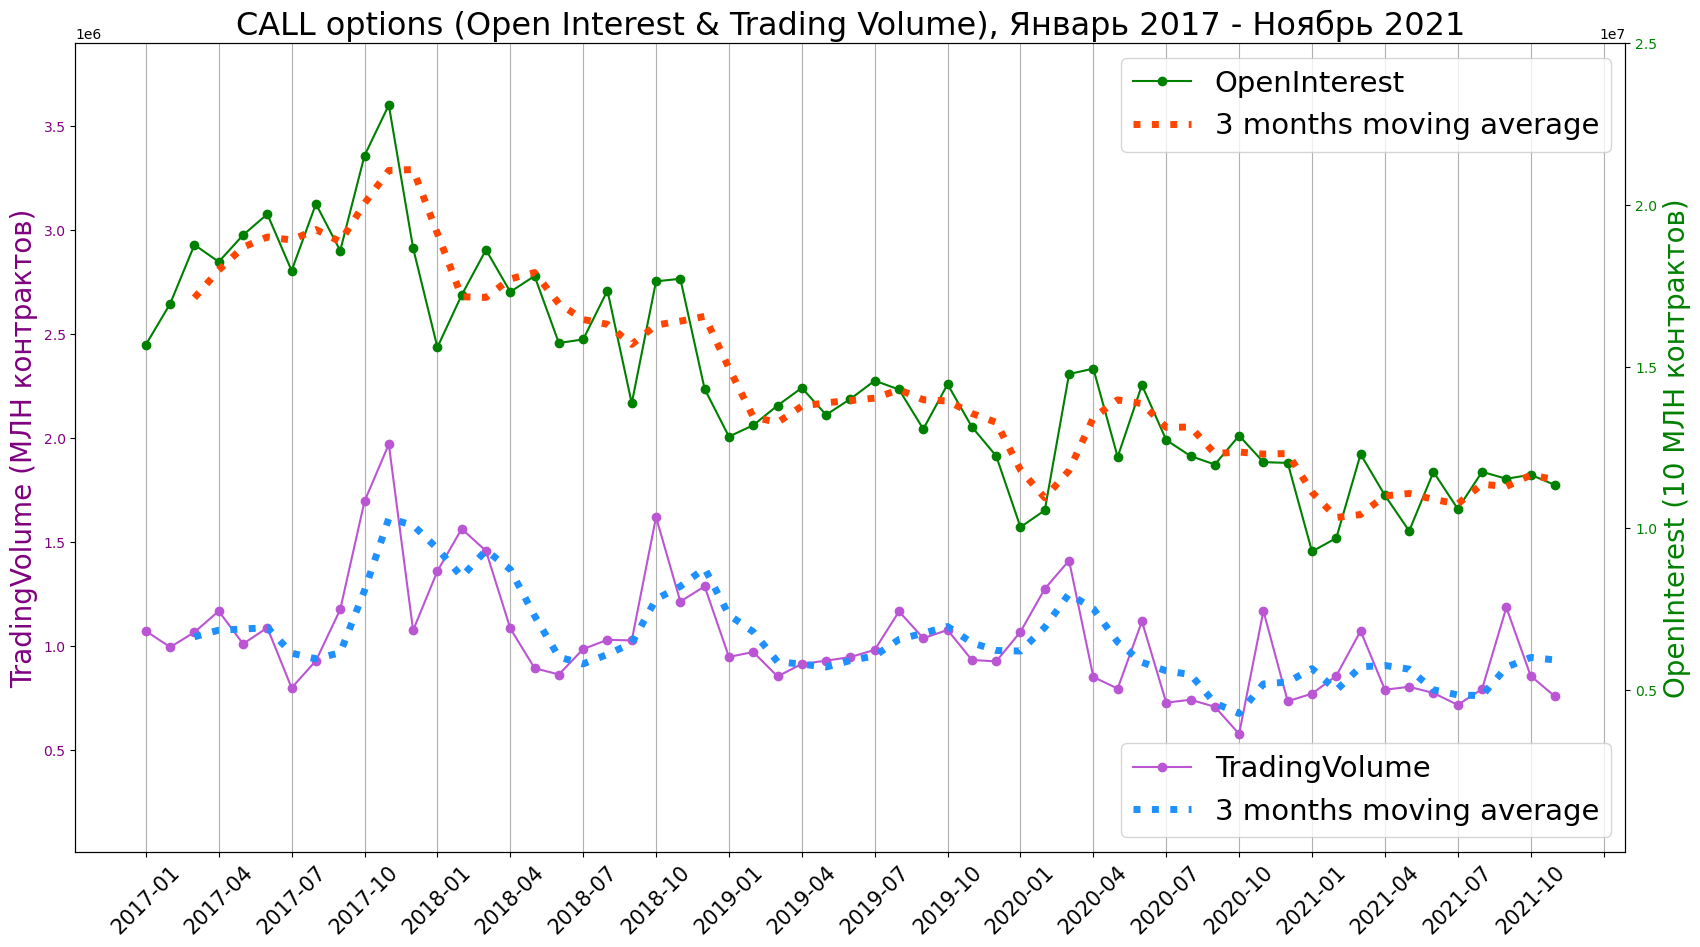

In [267]:
fig,ax = plt.subplots()

TradingVolume = ax.plot(list(call_stat.TradingVolume),
        color = 'mediumorchid',
         marker = 'o', 
         label='TradingVolume')

TM_3mean = ax.plot(list(call_stat['TM_3mean']),
        color = 'dodgerblue',
        linestyle = ':',
        linewidth = 5, 
         label='3 months moving average')

ax.set_ylabel("TradingVolume (МЛН контрактов)", 
              fontsize = 20)
plt.legend(fontsize = 21, loc = 4)

ax2 = ax.twinx() #____________________________________________

ax2.plot(list(call_stat.OpenInterest),
         color = 'green',
         marker = 'o', 
         label='OpenInterest')

ax2.plot(list(call_stat['OI_3mean']),
         color = 'orangered',
         linestyle = ':',
         linewidth = 5,
         label='3 months moving average')

ax2.set_ylabel("OpenInterest (10 МЛН контрактов)", 
              fontsize = 20)

#_____________________________________________________________

ax.set_xticks(range(len(call_stat)))
ax.set_xticklabels(["%s-%02d" % item for item in call_stat.index.tolist()], fontsize = 15, rotation = 45);
ax.grid(axis = 'x')

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3)) # значение 1 - все даты, 2 - через одну;

ax.set_ylim(10000, 3900000)
ax2.set_ylim(1,25000000)

[t.set_color('purple') for t in ax.yaxis.get_ticklines()]
[t.set_color('purple') for t in ax.yaxis.get_ticklabels()]
ax.yaxis.label.set_color('purple')

[t.set_color('green') for t in ax2.yaxis.get_ticklines()]
[t.set_color('green') for t in ax2.yaxis.get_ticklabels()]
ax2.yaxis.label.set_color('green')

# ax.set_yticklabels(list(call_stat.TradingVolume), Fontsize= 20)
# ax2.set_yticklabels(list(call_stat.OpenInterest), Fontsize= 20)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)
plt.title('CALL options (Open Interest & Trading Volume), Январь 2017 - Ноябрь 2021', fontsize = 23)
plt.legend(fontsize = 21)

plt.show()

# Импорт данных о базисном активе с quantapi за последние 16 лет (в ВКР не использовалось)

In [ ]:
# https://www.kaggle.com/code/artemburenok/hedging-portfolio-with-options-greeks-var

# https://quantapi.co/account/signup/

# my token quantapi f24ff72c956a889507ab1b43ff267d1d4c343526

# There are 4-5 parameters for an API Call:
# asset, token, d (which means duration), f (which means format), q(which means stock code, now available only to hkex asset)
# e.g. asset=gold, token=123456789xyz, d=1y (eg. 30d=30 days, 4w=4 week, 2m=2 months, 1y=1 year, etc.), f=csv (json or csv)
# Actual API call (use code at 6.):

### Импортируем данные о котировках commodities/indexes/currencies c сервиса quantapi за последние 16 лет (на базисные активы)

In [62]:
def get_quantapi(symbol, token, code, duration, format):
    query = 'https://quantapi.co/api/' + symbol + '/' + token + '/?d=' + duration + '&f=' + format
    code = '3988'
    df = pd.read_csv(query)
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    df['ticker'] = str(symbol)
    df = df.sort_values('date', ascending = True)  
    return df

In [64]:
commodities = pd.read_excel('D:/Учёба/ВКР/ВсеВыгрузки/commiditiesandindexesandcurrencies.xlsx')
commodities = list(commodities.gold.values)
token = 'f24ff72c956a889507ab1b43ff267d1d4c343526'
duration = '16y'
format = 'csv'
code = '3988'
commodities_df = pd.DataFrame()
for symbol in commodities:
    token = token
    duration = duration
    format = format
    df = get_quantapi(symbol, token, duration, format)
    commodities_df = pd.concat([commodities_df,df], ignore_index = True)
    
commodities_df.to_csv('C:/Users/pshein/Desktop/Другое/Учёба/quantapidata.csv')

print('Размерность итогового датафрейма с котировками: ', 
      commodities_df.shape, '\n')
print('Количество уникальных активов в выборке суммарно по всем имеющимся commodities / индексам и валютам: ',
      commodities_df.ticker.nunique())

commodities_df

KeyError: "['volume'] not in index"